In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import scipy as sp
import seaborn as sns

sns.set(style='ticks', context='paper',
        rc={'font.size': 6, 
            'axes.titlesize': 7,
            'axes.labelsize': 7,
            'axes.labelpad': 2,
            'xtick.labelsize': 5,
            'ytick.labelsize': 5,
            'legend.title_fontsize' : 5.5,
            'legend.fontsize' : 5.5,
            'legend.markerscale': 0.5,
            'axes.spines.top': False,
            'axes.spines.right': False,
            'axes.linewidth': 0.4,
            'xtick.major.width': 0.4,
            'ytick.major.width': 0.4,
            'xtick.major.size': 2.5,
            'ytick.major.size': 2.5,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.minor.width': 0.2,
            'ytick.minor.width': 0.2,
            'figure.constrained_layout.use': True,
            'figure.dpi': 200})

id_columns = ['architecture', 'kind', 'source', 'layer']

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu', 
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu', 
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu', 
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}


In [25]:
model = 'AlexNet'
pooling = 'max'
inits = ['unt','KaiUni', 'O', 'D']

data_s = pd.DataFrame()
for init in inits:
    dm = pd.read_csv(f'../../../results_marcc/untrained/eigmetrics_{init}|dataset:imagenet|pooling:{pooling}|grayscale:False.csv')
    dm = dm[ (dm['architecture'] == model)]
    ds = pd.read_csv(f'../../../results_marcc/untrained/eigspectra_{init}|dataset:imagenet|pooling:{pooling}|grayscale:False.csv')
    ds = ds[ (ds['architecture'] == model)]
    if init == 'unt':
        data_m = dm
        data_s = ds
    else:
       data_m = pd.concat([data_m, dm], ignore_index=True)
       data_s = pd.concat([data_s, ds], ignore_index=True)
        
data = pd.merge(data_m, data_s, on=id_columns)

layers = data.layer.unique()


if init == 'unt':
    de = pd.read_csv(f'../../results_marcc/untrained/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv')
else:
    de = pd.read_csv(f'../../results_marcc/untrained/encoding_{i}|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv')
de = de[ (de['kind'] == 'Untrained') ]
de = de[ (de['architecture'] == f'model')]


140184704000144
140183712526736
140183711388048
140184704001552
['features.1' 'features.4' 'features.7' 'features.9' 'features.11']


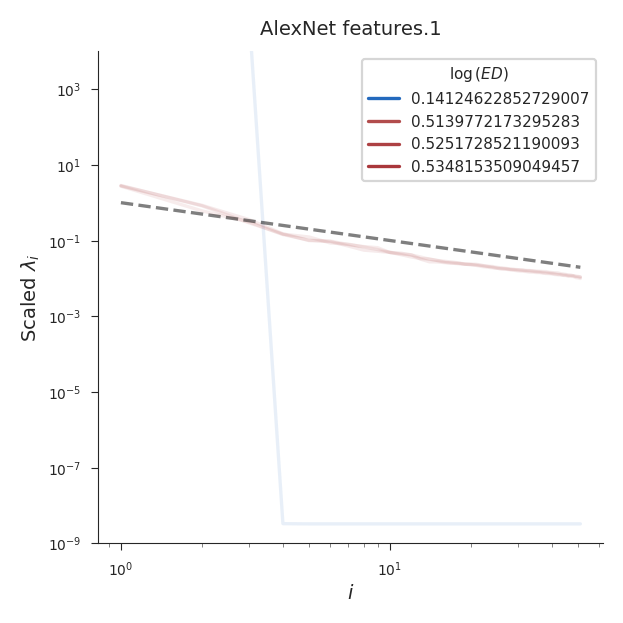

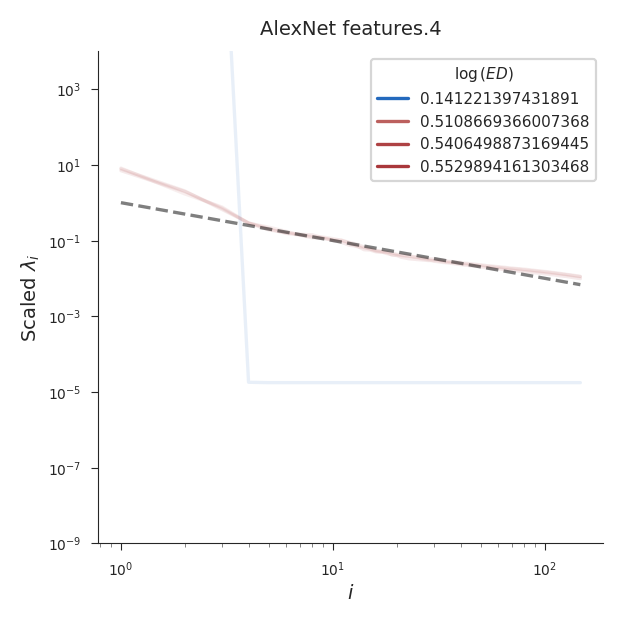

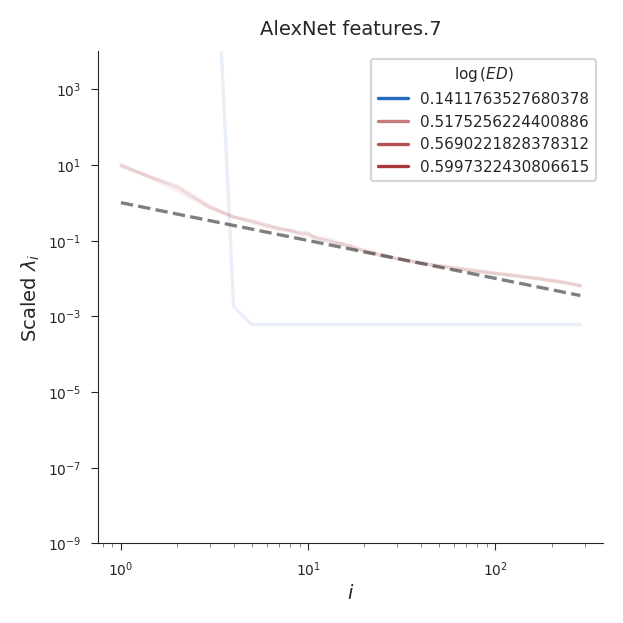

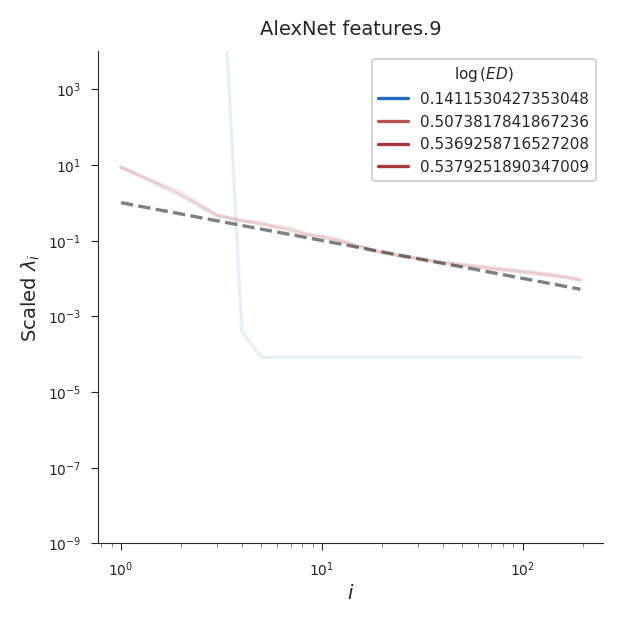

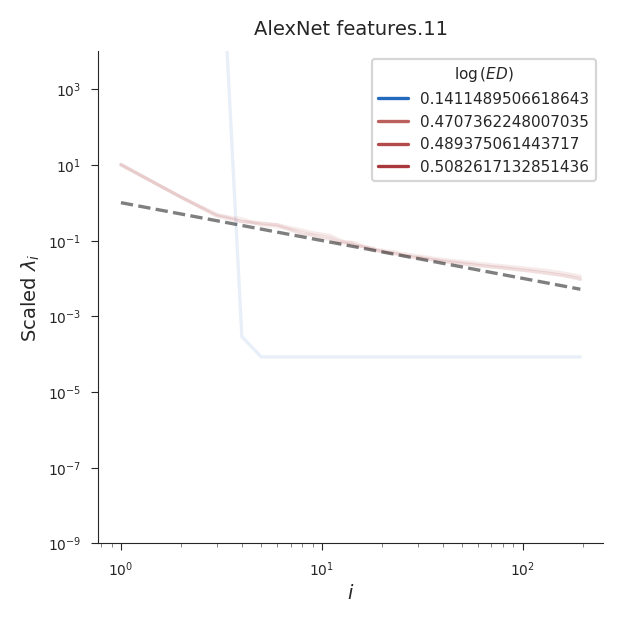

            layer  effective dimensionality  80% variance     alpha  \
0      features.1                  3.265707           8.0  1.379511   
1      features.1                  3.265707           8.0  1.379511   
2      features.1                  3.265707           8.0  1.379511   
3      features.1                  3.265707           8.0  1.379511   
4      features.1                  3.265707           8.0  1.379511   
...           ...                       ...           ...       ...   
4603  features.11                  1.384041           1.0  6.324787   
4604  features.11                  1.384041           1.0  6.324787   
4605  features.11                  1.384041           1.0  6.324787   
4606  features.11                  1.384041           1.0  6.324787   
4607  features.11                  1.384041           1.0  6.324787   

     architecture  task       kind   source    n      variance  \
0         AlexNet  None  Untrained  PyTorch    1  6.558208e+00   
1         AlexN

In [28]:
model = 'AlexNet'
pooling = 'max'
#inits = ['unt','KaiUni', 'O']
inits = ['unt','KaiUni', 'O', ]


data_s = pd.DataFrame()
for init in inits:
    dm = pd.read_csv(f'../../../results_marcc/untrained/eigmetrics_{init}|dataset:imagenet|pooling:{pooling}|grayscale:False.csv')
    dm = dm[ (dm['architecture'] == model)]
    ds = pd.read_csv(f'../../../results_marcc/untrained/eigspectra_{init}|dataset:imagenet|pooling:{pooling}|grayscale:False.csv')
    ds = ds[ (ds['architecture'] == model)]
    if init == 'unt':
        data_m = dm
        data_s = ds
    else:
       data_m = pd.concat([data_m, dm], ignore_index=True)
       data_s = pd.concat([data_s, ds], ignore_index=True)
       
data = pd.merge(data_m, data_s, on=id_columns)
data['id'] = data[id_columns].sum(axis='columns')

layers = data.layer.unique()
for layer in layers:
    data_l = data[ (data['layer'] == layer)]
    
# Remove outlier low-variance points at the final PCs
    def is_outlier(i):
        i = np.log(i)
        cutoff = 0.95 * i.iloc[-1]
        return i > cutoff
    outlier = data_l.groupby(id_columns)['n'].transform(is_outlier)
    data_l = data_l[~outlier]

# Set y-intercept to 1
    def get_scaled_var(x):
        i, y = x['n'].values, x['variance'].values
        i, y = np.log(i), np.log(y)
        intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
        intercept = np.exp(intercept)
        return x['variance'] / intercept
    scaled_var = data_l.groupby(id_columns).apply(get_scaled_var)
    scaled_var = scaled_var.reset_index(id_columns, drop=True)
    data_l['scaled_variance'] = scaled_var

# Log(ED)
    data_l['log_ed'] = np.log10(data_l['effective dimensionality'])

    fig, ax = plt.subplots(figsize=(3, 3))

    sns.lineplot(data=data_l, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
    ax.plot([1, data_l.n.max()], [1, 1 / data_l.n.max()], linestyle='--', color='black', alpha=0.5)
    ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title=f'AlexNet {layer}')
    ax.set_ylim(bottom=10**(-9), top=10**4)
    ax.legend(title=r'$\log{(ED)}$')

plt.show()
print(data[])


#encoding score